# Debug IonBeam Sources
The purpose of this notebook is to debug a particular source by running various components of its functionality and printing it. Input the target source below and it will be selected from the config.

In [1]:
# source_to_debug = "meteotracker"
source_to_debug = "smart_citizen_kit"
# source_to_debug = "acronet"

offline = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !pip install wurlitzer

In [4]:
%load_ext wurlitzer

In [5]:
import pandas as pd
import numpy as np
import logging
import pyfdb
import findlibs
import yaml
from pathlib import Path
import os
import pandas as pd
import pyodc
import shutil
from pathlib import Path
from ionbeam.core.config_parser import parse_config
from ionbeam.core.bases import *
from IPython.display import display
from matplotlib import pyplot as plt
from ionbeam.metadata.db import init_db

In [6]:
logging.basicConfig(level = logging.INFO)
logging.getLogger('matplotlib').setLevel(level = logging.WARNING)

print("Parsing config...")
config_file = Path("~/git/IonBeam-Deployment/config/ionbeam").expanduser()
config, actions = parse_config(config_file,
                    config_path = "./",
                    data_path = "../data/",
                    offline = offline,
                    environment  = "local",
                    sources = [source_to_debug]
                    )

if config.globals.environment == "local": 
    print("Wiping and initialising local database...")
    init_db(config.globals)

source = [a for a in actions if isinstance(a, Source)][0]

Parsing config...
Wiping and initialising local database...


INFO:ionbeam.metadata.db:Adding 'Sensor.Community' to Authors table
INFO:ionbeam.metadata.db:Adding 'Meteotracker' to Authors table
INFO:ionbeam.metadata.db:Adding 'Acronet' to Authors table
INFO:ionbeam.metadata.db:Adding 'SmartCitizenKit' to Authors table


In [7]:
source

id,04dac51f-84bd-4506-818f-d3e14d9c4743
mappings,"[InputColumn(name='time', key='time', type=None, unit=None, discard=False, canonical_variable=Non..."
finish_after,None
copy_metadata_to_columns,"[station_name, station_id, lat, lon, created_at, city, country, author]"
cache_version,3
use_cache,True
cache_directory,/Users/math/git/IonBeam-Deployment/data/inputs/smart_citizen_kit
name,value
source_action_id,04dac51f-84bd-4506-818f-d3e14d9c4743
state,raw
mars_request,{}


## Show the connection structure of the actions defined in the config

In [8]:
from ionbeam.core.config_parser import print_action_chains
print_action_chains(actions)

SmartCitizenKitSource --> CSVParser --> Splitter --> NewTimeAggregator --> ODCEncoder
[Match(state = 'odc_encoded')] --> RESTWriter()


## Show the raw data keys that are being extracted from the raw api data and which canonical variables they are mapped to

In [9]:
print("Source copies these external keys to these canonical variables:")
import pandas as pd
cvs = {c.name : c for c in config.globals.canonical_variables}
pd.DataFrame.from_records((dict(
                               source_key = c.key, source_unit = c.unit, 
                               discard = c.discard,
                               canonical_name = c.name if not c.discard else "",
                               canonical_unit = cvs[c.name].unit if not c.discard else "",
                                ) for c in source.mappings))

Source copies these external keys to these canonical variables:


,source_key,source_unit,discard,canonical_name,canonical_unit
0,time,None,False,time,None
1,device.name,None,False,station_name,None
2,station.external_id,None,False,station_id,None
3,device.name,None,False,author,None
4,device.location.latitude,EPSG:4326,False,lat,EPSG:4326
...,...,...,...,...,...
70,adc_48_3,V,True,,
71,adc_49_0,V,True,,
72,adc_49_1,V,True,,
73,adc_49_2,V,True,,


## Get source chunks for the last seven days

In [10]:
from datetime import datetime, timedelta, timezone
import itertools as it

now = datetime.now(tz=timezone.utc)
earlier = now - timedelta(days = 7)

chunk_iterable = source.get_chunks(earlier, now)
chunks = list(it.islice(chunk_iterable, 20))
chunks[0].keys()

dict_keys(['key', 'device_id', 'start_date', 'end_date', 'device'])

## Download one of those chunks

In [11]:
raw_messages = list(source.download_chunk(chunks[0]))      
print(f"{len(raw_messages) = }")

len(raw_messages) = 1


In [12]:
msg = raw_messages[0]
msg.data

,time,tvoc,eco2,light,noise_dba,no2,bar,o3,pm_avg_1,pm_avg_10,pm_avg_2.5,pm_pn0.3,pm_pn0.5,pm_pn1.0,pm_pn10.0,pm_pn2.5,pm_pn5.0,h,t
0,2024-08-02 10:00:26+00:00,0.0,400.0,1800,58.93,11.689215,100.61,76.410372,7,16,14,NaN,NaN,NaN,NaN,NaN,NaN,50.42,36.47
1,2024-08-02 11:00:26+00:00,0.0,400.0,1866,61.59,28.085903,100.61,33.596467,6,15,12,NaN,NaN,NaN,NaN,NaN,NaN,49.15,38.05
2,2024-08-02 12:00:26+00:00,0.0,400.0,1584,73.47,52.936197,100.58,14.666354,9,16,15,NaN,NaN,NaN,NaN,NaN,NaN,51.14,38.77
3,2024-08-02 13:00:26+00:00,0.0,400.0,1488,65.20,26.553748,100.56,83.438428,10,18,16,NaN,NaN,NaN,NaN,NaN,NaN,51.31,38.50
4,2024-08-02 14:00:26+00:00,3.0,421.0,1047,59.04,59.391990,100.52,26.904628,9,21,19,NaN,NaN,NaN,NaN,NaN,NaN,59.56,34.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2024-08-09 05:00:18+00:00,0.0,400.0,65,63.49,21.749220,101.12,-7.343866,10,18,17,NaN,NaN,NaN,NaN,NaN,NaN,83.32,23.63
158,2024-08-09 06:00:18+00:00,0.0,400.0,302,54.41,32.546468,101.12,-8.584051,10,20,20,NaN,NaN,NaN,NaN,NaN,NaN,77.47,25.71
159,2024-08-09 07:00:18+00:00,0.0,400.0,681,59.73,29.968410,101.18,-4.702791,11,22,21,NaN,NaN,NaN,NaN,NaN,NaN,69.39,29.39
160,2024-08-09 08:00:18+00:00,0.0,400.0,1144,63.52,23.989251,101.23,-8.409087,13,20,20,NaN,NaN,NaN,NaN,NaN,NaN,62.40,33.75


## Use the actual interface so that extra steps like copying metadata over get done

In [13]:
raw_messages = list(it.islice(source.generate(), 5))
len(raw_messages)


Sensor: {'id': 103, 'ancestry': '70', 'name': 'PMS5003_A_PN5.0', 'description': 'Particle Matter (A) PN5.0', 'unit': '#/0.1L', 'created_at': '2019-02-27T12:30:15Z', 'updated_at': '2019-02-27T12:30:15Z', 'uuid': '9696649e-fc4a-416a-b439-0d7dec824a3d', 'default_key': 'pm_a_pn5.0', 'datasheet': None, 'unit_definition': None, 'measurement': {'id': 44, 'name': 'PN5.0', 'description': 'Particle Number Concentration from previous size to 5.0um', 'unit': None, 'uuid': '0302d18b-fdff-42c1-9121-a9178e4212c8', 'definition': None}, 'value': '\x07h23\x078.9[', 'prev_value': '\x07h23\x078.9[', 'last_reading_at': '2024-02-23T05:58:41Z', 'tags': []}



5

In [14]:
raw_messages[0].data.columns

Index(['time', 'tvoc', 'eco2', 'light', 'noise_dba', 'bar', 'pm_avg_1',
       'pm_avg_10', 'pm_avg_2.5', 'pm_pn0.3', 'pm_pn0.5', 'pm_pn1.0',
       'pm_pn10.0', 'pm_pn2.5', 'pm_pn5.0', 'co2', 'ext_h', 'ext_t', 'h', 't',
       'station_name', 'station_id', 'lat', 'lon', 'created_at', 'city',
       'country', 'author'],
      dtype='object')

In [15]:
raw_messages[0].data

,time,tvoc,eco2,light,noise_dba,bar,pm_avg_1,pm_avg_10,pm_avg_2.5,pm_pn0.3,...,h,t,station_name,station_id,lat,lon,created_at,city,country,author
0,2024-07-16 13:43:02+00:00,33.0,620.0,26,60.48,100.31,NaN,NaN,NaN,NaN,...,64.24,29.44,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
1,2024-07-16 13:44:02+00:00,34.0,624.0,25,48.47,100.31,NaN,NaN,NaN,NaN,...,64.46,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
2,2024-07-16 13:45:02+00:00,33.0,620.0,25,64.78,100.31,NaN,NaN,NaN,NaN,...,64.68,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
3,2024-07-16 13:46:02+00:00,33.0,620.0,26,50.82,100.31,NaN,NaN,NaN,NaN,...,64.51,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
4,2024-07-16 13:47:02+00:00,33.0,620.0,29,62.20,100.31,1.0,5.0,4.0,NaN,...,64.50,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10025,2024-07-23 13:36:24+00:00,36.0,641.0,13,44.01,100.31,NaN,NaN,NaN,NaN,...,60.33,32.37,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10026,2024-07-23 13:37:24+00:00,36.0,641.0,13,52.56,100.31,13.0,22.0,19.0,NaN,...,60.68,32.35,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10027,2024-07-23 13:38:24+00:00,36.0,641.0,13,57.55,100.31,NaN,NaN,NaN,NaN,...,60.80,32.35,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10028,2024-07-23 13:39:24+00:00,35.0,634.0,13,63.01,100.31,NaN,NaN,NaN,NaN,...,60.96,32.35,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA


## Check the metadata that got loaded in by this

In [16]:
import json
from sqlalchemy.orm import Session
from ionbeam.metadata import db

with Session(config.globals.sql_engine) as session:
    stations = session.query(db.Station).all()
    for s in stations:
        s = s.as_json()
        del s["geojson"]
        print(s.keys())
        for k in ["name", "description", "external_id"]:
            print(f"{k}: {s[k]}")
        print(f"Properties: {[p['name'] for p in s['sensors'][0]['properties']]}")
        print()

dict_keys(['name', 'description', 'platform', 'external_id', 'location', 'time_span', 'authors', 'sensors'])
name: I-CHANGE CIMA CORSO EUROPA 2024
description: Smart Citizen Kit
external_id: 17054
Properties: ['total_volatile_organic_compounds', 'equivalent_carbon_dioxide']

dict_keys(['name', 'description', 'platform', 'external_id', 'location', 'time_span', 'authors', 'sensors'])
name: I-CHANGE CIMA CASTAGNA
description: Smart Citizen Kit 2.1 with Urban Sensor Board
external_id: 16643
Properties: ['total_volatile_organic_compounds', 'equivalent_carbon_dioxide']

dict_keys(['name', 'description', 'platform', 'external_id', 'location', 'time_span', 'authors', 'sensors'])
name: I-CHANGE MELE NEW
description: Smart Citizen Kit 2.1 with Urban Sensor Board
external_id: 16763
Properties: ['total_volatile_organic_compounds', 'equivalent_carbon_dioxide']



## Pass a message through the CSVParser

In [17]:
from IPython.display import display

def display_columns(cols):
    display(pd.DataFrame.from_records((dict(key = c.key,  
                               discard = c.discard,
                               name = c.name if not c.discard else "", 
                                source_unit = c.unit,
                               unit = cvs[c.name].unit if not c.discard else "", ) for c in cols), index = "name"))


csv_parser = [a for a in actions if isinstance(a, Parser)][0]
print("Columns that will be present in all output because they represent metadata")
display_columns(csv_parser.fixed_columns)

print("\n\nData Columns")
display_columns(csv_parser.value_columns)

Columns that will be present in all output because they represent metadata


,key,discard,source_unit,unit
name,,,,
time,time,False,None,None
station_name,device.name,False,None,None
station_id,station.external_id,False,None,None
author,device.name,False,None,None
lat,device.location.latitude,False,EPSG:4326,EPSG:4326
lon,device.location.longitude,False,EPSG:4326,EPSG:4326
created_at,device.created_at,False,None,None
city,device.location.city,False,None,None
country,device.location.country,False,None,None




Data Columns


,key,discard,source_unit,unit
name,,,,
total_volatile_organic_compounds,TVOC,False,ppb,ppb
total_volatile_organic_compounds,tvoc,False,ppb,ppb
equivalent_carbon_dioxide,eco2,False,ppm,ppm
equivalent_carbon_dioxide,eCO2,False,ppm,ppm
ambient_light,Light,False,lux,lux
ambient_light,light,False,lux,lux
noise_dB,Noise Level,False,dB,dB
noise_dBA,Noise Level,False,dBA,dBA
noise_dBA,noise_dba,False,dBA,dBA


In [18]:
raw_messages[0].data

,time,tvoc,eco2,light,noise_dba,bar,pm_avg_1,pm_avg_10,pm_avg_2.5,pm_pn0.3,...,h,t,station_name,station_id,lat,lon,created_at,city,country,author
0,2024-07-16 13:43:02+00:00,33.0,620.0,26,60.48,100.31,NaN,NaN,NaN,NaN,...,64.24,29.44,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
1,2024-07-16 13:44:02+00:00,34.0,624.0,25,48.47,100.31,NaN,NaN,NaN,NaN,...,64.46,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
2,2024-07-16 13:45:02+00:00,33.0,620.0,25,64.78,100.31,NaN,NaN,NaN,NaN,...,64.68,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
3,2024-07-16 13:46:02+00:00,33.0,620.0,26,50.82,100.31,NaN,NaN,NaN,NaN,...,64.51,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
4,2024-07-16 13:47:02+00:00,33.0,620.0,29,62.20,100.31,1.0,5.0,4.0,NaN,...,64.50,29.45,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10025,2024-07-23 13:36:24+00:00,36.0,641.0,13,44.01,100.31,NaN,NaN,NaN,NaN,...,60.33,32.37,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10026,2024-07-23 13:37:24+00:00,36.0,641.0,13,52.56,100.31,13.0,22.0,19.0,NaN,...,60.68,32.35,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10027,2024-07-23 13:38:24+00:00,36.0,641.0,13,57.55,100.31,NaN,NaN,NaN,NaN,...,60.80,32.35,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10028,2024-07-23 13:39:24+00:00,35.0,634.0,13,63.01,100.31,NaN,NaN,NaN,NaN,...,60.96,32.35,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09T06:37:25Z,Castagna,Italy,I-CHANGE CIMA CASTAGNA


In [19]:
df = csv_parser.format_dataframe(raw_messages[0].data)
df

,time,total_volatile_organic_compounds,equivalent_carbon_dioxide,ambient_light,noise_dBA,air_pressure_near_surface,particulate_matter_1,particulate_matter_10,particulate_matter_2_5,particulate_matter_particle_number_0_3,...,relative_humidity_near_surface,air_temperature_near_surface,station_name,station_id,lat,lon,created_at,city,country,author
0,2024-07-16 13:43:02+00:00,33.0,620.0,26.0,60.48,100310000.0,NaN,NaN,NaN,NaN,...,64.24,848.89,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
1,2024-07-16 13:44:02+00:00,34.0,624.0,25.0,48.47,100310000.0,NaN,NaN,NaN,NaN,...,64.46,848.90,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
2,2024-07-16 13:45:02+00:00,33.0,620.0,25.0,64.78,100310000.0,NaN,NaN,NaN,NaN,...,64.68,848.90,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
3,2024-07-16 13:46:02+00:00,33.0,620.0,26.0,50.82,100310000.0,NaN,NaN,NaN,NaN,...,64.51,848.90,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
4,2024-07-16 13:47:02+00:00,33.0,620.0,29.0,62.20,100310000.0,1.0,5.0,4.0,NaN,...,64.50,848.90,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10025,2024-07-23 13:36:24+00:00,36.0,641.0,13.0,44.01,100310000.0,NaN,NaN,NaN,NaN,...,60.33,851.82,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10026,2024-07-23 13:37:24+00:00,36.0,641.0,13.0,52.56,100310000.0,13.0,22.0,19.0,NaN,...,60.68,851.80,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10027,2024-07-23 13:38:24+00:00,36.0,641.0,13.0,57.55,100310000.0,NaN,NaN,NaN,NaN,...,60.80,851.80,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA
10028,2024-07-23 13:39:24+00:00,35.0,634.0,13.0,63.01,100310000.0,NaN,NaN,NaN,NaN,...,60.96,851.80,I-CHANGE CIMA CASTAGNA,16643,44.49617,8.92065,2023-10-09 06:37:25+00:00,Castagna,Italy,I-CHANGE CIMA CASTAGNA


In [20]:
def pump_through(action, messages):
    return [out_msg
           for in_msg in messages
           for out_msg in action.process(in_msg)]

parsed_messages = pump_through(csv_parser, raw_messages)

In [21]:
from datetime import time, datetime

message = parsed_messages[0]
for (date, hour), chunk in message.data.groupby([message.data.time.dt.date, message.data.time.dt.hour]):
    start_time = datetime.combine(date, time(hour=hour))
    


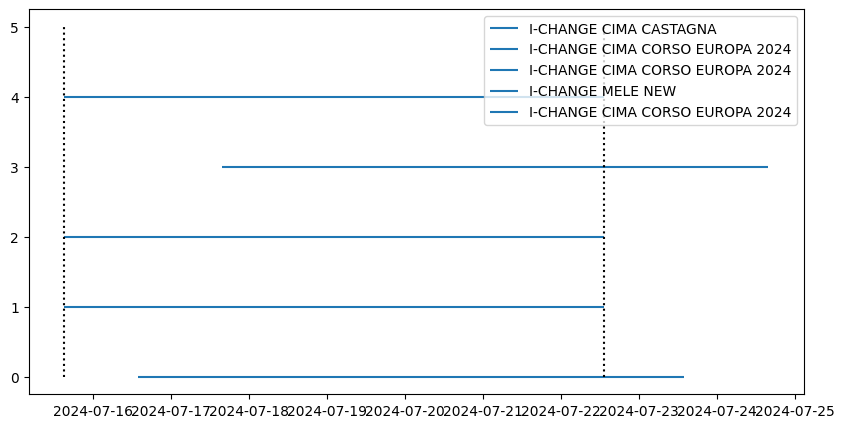

In [22]:

f, ax1 = plt.subplots(figsize = [10,5])
for i, m in enumerate(parsed_messages):
    t = m.data.time
    start, end = m.data.time.min(), m.data.time.max()
    ax1.hlines(y = i, xmin = start, xmax = end, label = m.data.station_name.iloc[0])
    # print(start, end)

ax1.vlines(x = [start, end], ymin = 0, ymax = len(parsed_messages), linestyle = "dotted", color = "k")
ax1.legend()

In [31]:
print("Parsing config...")
config_file = Path("~/git/IonBeam-Deployment/config/ionbeam").expanduser()
config, actions = parse_config(config_file,
                    config_path = "./",
                    data_path = "../data/",
                    offline = offline,
                    environment  = "local",
                    sources = [source_to_debug]
                    )
[a.__class__ for a in actions]

Parsing config...


[ionbeam.sources.smart_citizen_kit.source.SmartCitizenKitSource,
 ionbeam.parsers.csv.CSVParser,
 ionbeam.parsers.splitter.Splitter,
 ionbeam.aggregators.by_time_2.NewTimeAggregator,
 ionbeam.encoders.odb.ODCEncoder,
 ionbeam.writers.rest_writer.RESTWriter]

In [32]:
from ionbeam.aggregators import NewTimeAggregator
from ionbeam.parsers import Splitter

# splitter = [a for a in actions if isinstance(a, Splitter)][0]
time_aggregator = [a for a in actions if isinstance(a, NewTimeAggregator)][0]

# split_messages = pump_through(splitter, parsed_messages)
# print(f"{len(split_messages)=}")

IndexError: list index out of range

In [25]:
aggregated_messages = pump_through(time_aggregator, parsed_messages)

# Force the aggregator to dumps its contents even if it's not happy about it 
unhappy_aggregated_messages = list(time_aggregator.process(FinishMessage("We're done!")))

aggregated_messages


              Got message spanning time 2024-07-16 13:43:02 - 2024-07-23 13:40:24
              Spanning 6 days 23:57:22
              Going forwards
              Emit frontier = 2024-07-09 13:45:40
              self.min_emit_after_hours=167.9561111111111
              self.time_frontier=Timestamp('2024-07-16 13:43:02')    
              


TypeError: Cannot convert tz-naive timestamps, use tz_localize to localize

In [ ]:
f, ax1 = plt.subplots(figsize = [10,5])
for i, m in enumerate(aggregated_messages):
    t = m.data.time
    start, end = m.data.time.min(), m.data.time.max()
    ax1.hlines(y = i, xmin = start, xmax = end)
    # print(start, end)

for i, m in enumerate(unhappy_aggregated_messages):
    t = m.data.time
    start, end = m.data.time.min(), m.data.time.max()
    ax1.hlines(y = i, xmin = start, xmax = end, color= "red")
    # print(start, end)

ax1.vlines(x = [start, end], ymin = 0, ymax = len(parsed_messages), linestyle = "dotted", color = "k")